In [1]:
import os

class Config:
    train_img_dir = os.path.abspath(os.path.join('..', 'data', 'train'))
    val_img_dir = os.path.abspath(os.path.join('..', 'data', 'val'))
    test_img_dir = os.path.abspath(os.path.join('..', 'data', 'test'))

    train_fixations_json = os.path.abspath(os.path.join('..', 'data', 'fixations_train2014.json'))
    val_fixations_json = os.path.abspath(os.path.join('..', 'data', 'fixations_val2014.json'))

    image_size = (256, 192)
    saliency_size = (256, 192)

    batch_size = 4
    num_workers = 4
    num_epochs = 10
    learning_rate = 1e-4
    weight_decay = 1e-5

    timesteps = 100
    beta_start = 1e-4
    beta_end = 0.02

    output_dir = os.path.abspath('./saliency_diffusion_outputs')
    checkpoint_path = os.path.join(output_dir, 'saliency_diffusion_unet.pt')
    sample_dir = os.path.join(output_dir, 'samples')
    gt_saliency_dir = os.path.abspath('./saliency_ground_truth')
    train_saliency_dir = os.path.join(gt_saliency_dir, 'train')
    val_saliency_dir = os.path.join(gt_saliency_dir, 'val')

    device = 'cuda' if os.environ.get('CUDA_VISIBLE_DEVICES') is not None else 'cuda' if __import__('torch').cuda.is_available() else 'cpu'

cfg = Config()
for path in [cfg.output_dir, cfg.sample_dir, cfg.gt_saliency_dir, cfg.train_saliency_dir, cfg.val_saliency_dir]:
    os.makedirs(path, exist_ok=True)
cfg.__dict__

{}

In [2]:
import json
from typing import Dict, List, Tuple, Optional
import numpy as np
from PIL import Image
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import math

print('Using device:', cfg.device)
print('Train dir exists:', os.path.isdir(cfg.train_img_dir))
print('Val dir exists:', os.path.isdir(cfg.val_img_dir))
print('Test dir exists:', os.path.isdir(cfg.test_img_dir))
print('Train fixations JSON exists:', os.path.isfile(cfg.train_fixations_json))
print('Val fixations JSON exists:', os.path.isfile(cfg.val_fixations_json))


Using device: cuda
Train dir exists: True
Val dir exists: True
Test dir exists: True
Train fixations JSON exists: True
Val fixations JSON exists: True


In [3]:
def load_json(path: str) -> Dict:
    with open(path, 'r') as f:
        return json.load(f)
    
def parse_fixations_json(fixations: Dict, split: str, cache_dir: Optional[str] = None) -> Dict[str, np.ndarray]:
    """Parse SALICON-style fixation annotations into dense saliency maps."""
    if not fixations:
        return {}

    if cache_dir:
        os.makedirs(cache_dir, exist_ok=True)

    # Map image id to file metadata
    img_meta: Dict[int, str] = {}
    dims: Dict[str, Tuple[int, int]] = {}
    for img in fixations.get('images', []):
        img_id = img.get('id')
        fname = img.get('file_name')
        if img_id is None or not fname:
            continue
        img_meta[img_id] = fname
        width = img.get('width')
        height = img.get('height')
        if width and height:
            dims[fname] = (int(width), int(height))

    # Aggregate fixation points per image filename
    mapping: Dict[str, List[Tuple[float, float]]] = {}
    for ann in fixations.get('annotations', []):
        img_id = ann.get('image_id')
        fname = img_meta.get(img_id)
        if not fname:
            continue
        pts = ann.get('fixations') or ann.get('points') or []
        if not pts:
            continue
        bucket = mapping.setdefault(fname, [])
        for p in pts:
            if not isinstance(p, (list, tuple)) or len(p) < 2:
                continue
            try:
                row = float(p[0])
                col = float(p[1])
            except (TypeError, ValueError):
                continue
            if np.isnan(row) or np.isnan(col):
                continue
            # SALICON fixations are 1-indexed (row, col) == (y, x)
            y = row - 1.0
            x = col - 1.0
            bucket.append((y, x))

    saliency_maps: Dict[str, np.ndarray] = {}
    W, H = cfg.saliency_size

    processed = 0
    filenames = sorted(set(img_meta.values()))
    for fname in filenames:
        sal_map = np.zeros((H, W), dtype=np.float32)
        pts = mapping.get(fname, [])
        orig_w, orig_h = dims.get(fname, (None, None))

        if pts:
            for y, x in pts:
                if orig_w and orig_h and orig_w > 1 and orig_h > 1:
                    sy = (y / max(1.0, orig_h - 1)) * (H - 1)
                    sx = (x / max(1.0, orig_w - 1)) * (W - 1)
                else:
                    sy, sx = y, x

                iy = int(round(np.clip(sy, 0, H - 1)))
                ix = int(round(np.clip(sx, 0, W - 1)))
                sal_map[iy, ix] += 1.0

            if sal_map.max() > 0:
                sal_map /= sal_map.max()

        saliency_maps[fname] = sal_map
        processed += 1

        if cache_dir:
            stem = os.path.splitext(fname)[0]
            cache_path = os.path.join(cache_dir, f'{stem}.npy')
            np.save(cache_path, sal_map)

    msg_prefix = f"{split.capitalize()} saliency maps"
    if cache_dir:
        print(f"{msg_prefix}: saved {processed} arrays to {cache_dir}")
    else:
        print(f"{msg_prefix}: generated {processed} arrays in memory")

    return saliency_maps
    
try:
    train_fix_raw = load_json(cfg.train_fixations_json)
    val_fix_raw = load_json(cfg.val_fixations_json)
    print('Loaded fixation JSONs.')
except Exception as e:
    print('Error loading or parsing fixation JSONs. Please adapt parse_fixations_json to your format.')
    print(e)
    train_fix_raw, val_fix_raw = None, None

Loaded fixation JSONs.


In [4]:
train_saliency_maps = parse_fixations_json(train_fix_raw, split='train', cache_dir=cfg.train_saliency_dir) if train_fix_raw is not None else {}
val_saliency_maps = parse_fixations_json(val_fix_raw, split='val', cache_dir=cfg.val_saliency_dir) if val_fix_raw is not None else {}

print('Train saliency entries in memory:', len(train_saliency_maps))
print('Val saliency entries in memory:', len(val_saliency_maps))

Train saliency maps: saved 10000 arrays to /home/oosulliv/projects/Computer-Vision/notebooks/saliency_ground_truth/train
Val saliency maps: saved 5000 arrays to /home/oosulliv/projects/Computer-Vision/notebooks/saliency_ground_truth/val
Train saliency entries in memory: 10000
Val saliency entries in memory: 5000
Val saliency maps: saved 5000 arrays to /home/oosulliv/projects/Computer-Vision/notebooks/saliency_ground_truth/val
Train saliency entries in memory: 10000
Val saliency entries in memory: 5000


Train dataset size: 10000
Val dataset size: 5000
Batch shapes: torch.Size([4, 3, 192, 256]) torch.Size([4, 1, 192, 256])
Batch shapes: torch.Size([4, 3, 192, 256]) torch.Size([4, 1, 192, 256])


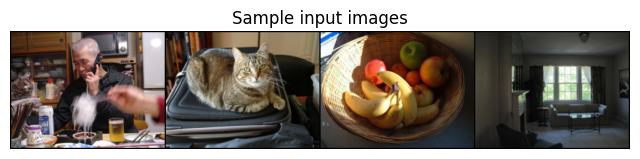

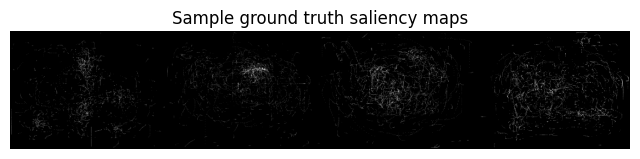

In [5]:
class SaliconSaliencyDataset(Dataset):
    def __init__(self, img_dir: str, saliency_maps: Dict[str, np.ndarray], image_size=(256, 192), saliency_cache_dir: Optional[str] = None):
        self.img_dir = img_dir
        self.saliency_maps = saliency_maps or {}
        self.saliency_cache_dir = saliency_cache_dir
        self.image_size = image_size

        # Collect only images that have saliency info (either in-memory or cached on disk)
        self.image_files = [f for f in os.listdir(img_dir) if self._has_saliency(f)]
        self.image_files.sort()

        self.img_transform = transforms.Compose([
            transforms.Resize((image_size[1], image_size[0])),
            transforms.ToTensor(),
        ])

        # Saliency maps are kept in [0,1] range, single-channel

    def _has_saliency(self, fname: str) -> bool:
        if fname in self.saliency_maps:
            return True
        if not self.saliency_cache_dir:
            return False
        cache_path = os.path.join(self.saliency_cache_dir, f"{os.path.splitext(fname)[0]}.npy")
        return os.path.isfile(cache_path)

    def _load_saliency(self, fname: str) -> np.ndarray:
        sal_map = self.saliency_maps.get(fname)
        if sal_map is None and self.saliency_cache_dir:
            cache_path = os.path.join(self.saliency_cache_dir, f"{os.path.splitext(fname)[0]}.npy")
            if os.path.isfile(cache_path):
                sal_map = np.load(cache_path, allow_pickle=False)
        if sal_map is None:
            raise KeyError(f'No saliency map found for {fname}.')
        return sal_map

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        fname = self.image_files[idx]
        img_path = os.path.join(self.img_dir, fname)

        img = Image.open(img_path).convert('RGB')
        img = self.img_transform(img)

        sal_map = self._load_saliency(fname)
        H, W = self.image_size[1], self.image_size[0]
        if sal_map.shape != (H, W):
            sal_img = Image.fromarray((sal_map * 255).astype(np.uint8))
            sal_img = sal_img.resize((W, H), resample=Image.BILINEAR)
            sal_tensor = torch.from_numpy(np.array(sal_img)).float() / 255.0
        else:
            sal_tensor = torch.from_numpy(sal_map).float()
        sal_tensor = sal_tensor.unsqueeze(0)  # (1, H, W)

        return img, sal_tensor, fname
    
train_dataset = SaliconSaliencyDataset(
    cfg.train_img_dir,
    train_saliency_maps,
    image_size=cfg.image_size,
    saliency_cache_dir=cfg.train_saliency_dir
)
val_dataset = SaliconSaliencyDataset(
    cfg.val_img_dir,
    val_saliency_maps,
    image_size=cfg.image_size,
    saliency_cache_dir=cfg.val_saliency_dir
)

train_loader = DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True, num_workers=cfg.num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers, pin_memory=True)

print('Train dataset size:', len(train_dataset))
print('Val dataset size:', len(val_dataset))

batch = next(iter(train_loader)) if len(train_dataset) > 0 else None
if batch is not None:
    imgs, sal_maps, fnames = batch
    print('Batch shapes:', imgs.shape, sal_maps.shape)
    grid = vutils.make_grid(imgs, nrow=min(4, imgs.size(0)))
    plt.figure(figsize=(8, 4))
    plt.title('Sample input images')
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

    grid_sal = vutils.make_grid(sal_maps, nrow=min(4, sal_maps.size(0)))
    plt.figure(figsize=(8, 4))
    plt.title('Sample ground truth saliency maps')
    plt.imshow(grid_sal[0].cpu(), cmap='gray', vmin=0.0, vmax=1.0) #cmap = hot
    plt.axis('off')
    plt.show()
else:
    print('Warning: Train dataset is empty. Check your paths and JSON mapping.')

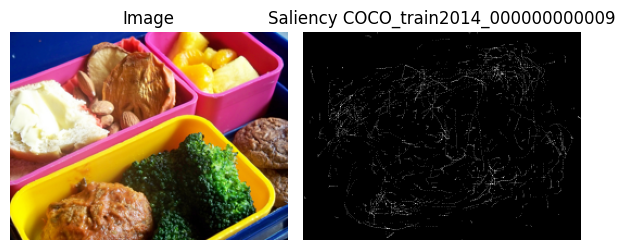

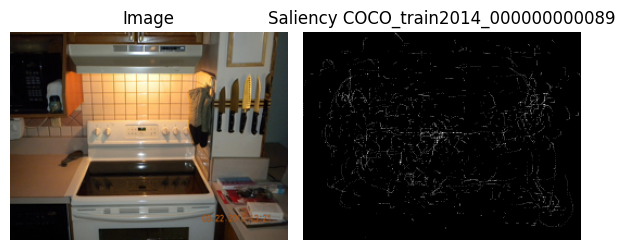

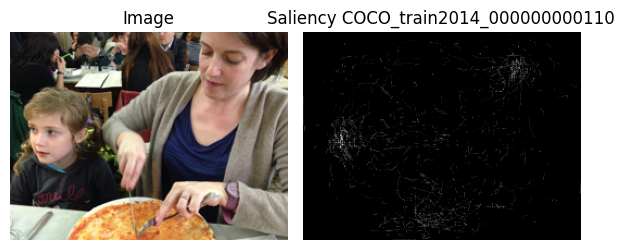

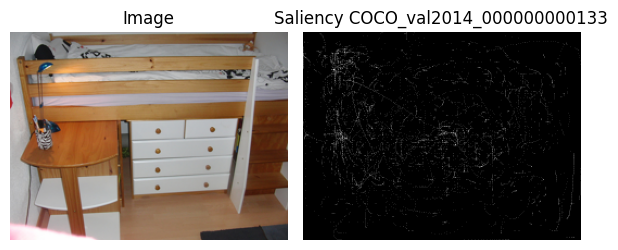

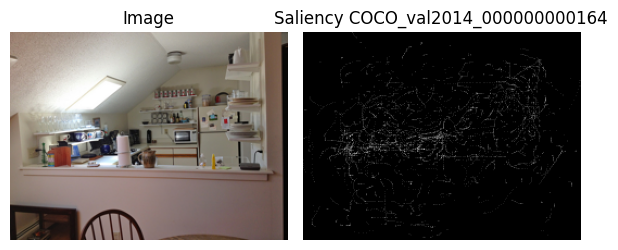

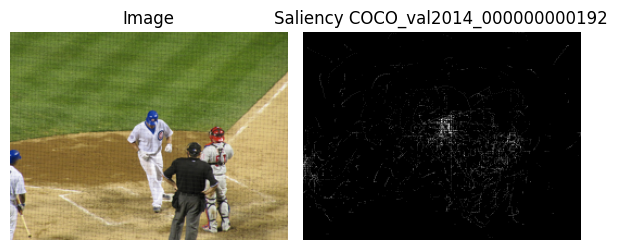

In [6]:
import glob
def visualize_cached_saliency(split: str = 'train', num_samples: int = 3):
    cache_dir = cfg.train_saliency_dir if split == 'train' else cfg.val_saliency_dir
    img_dir = cfg.train_img_dir if split == 'train' else cfg.val_img_dir
    if not os.path.isdir(cache_dir):
        print(f'Cache directory not found: {cache_dir}')
        return

    saliency_paths = sorted(glob.glob(os.path.join(cache_dir, '*.npy')))
    if not saliency_paths:
        print(f'No cached saliency maps found in {cache_dir}')
        return

    for npy_path in saliency_paths[:max(0, num_samples)]:
        sal_map = np.load(npy_path)
        base = os.path.splitext(os.path.basename(npy_path))[0]
        candidates = sorted(glob.glob(os.path.join(img_dir, base + '.*')))
        img = None
        if candidates:
            try:
                img = Image.open(candidates[0]).convert('RGB')
                img = img.resize(cfg.image_size)
            except Exception as exc:
                print(f'Failed to load image for {base}: {exc}')
                img = None

        if img is not None:
            fig, axs = plt.subplots(1, 2, figsize=(6, 3))
            axs[0].imshow(img)
            axs[0].set_title('Image')
            axs[0].axis('off')
            axs[1].imshow(sal_map, cmap='gray', vmin=0.0, vmax=1.0)
            axs[1].set_title(f'Saliency {base}')
            axs[1].axis('off')
        else:
            fig, ax = plt.subplots(1, 1, figsize=(3, 3))
            ax.imshow(sal_map, cmap='gray', vmin=0.0, vmax=1.0)
            ax.set_title(f'Saliency {base}')
            ax.axis('off')
        plt.tight_layout()
        plt.show()

visualize_cached_saliency('train', num_samples=3)
visualize_cached_saliency('val', num_samples=3)

In [7]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.act = nn.ReLU(inplace=True)
        self.time_mlp = None
        if time_emb_dim is not None:
            self.time_mlp = nn.Sequential(
                nn.Linear(time_emb_dim, out_ch),
                nn.ReLU(inplace=True)
            )

    def forward(self, x, t_emb=None):
        h = self.conv1(x)
        if self.time_mlp is not None and t_emb is not None:
            # Add time embedding (broadcast over spatial dims)
            temb = self.time_mlp(t_emb)[:, :, None, None]
            h = h + temb
        h = self.act(h)
        h = self.conv2(h)
        h = self.act(h)
        return h

# Sinusoidal positional time embeddings
def sinusoidal_time_embedding(t: torch.Tensor, dim: int) -> torch.Tensor:
    # t: (B,) in [0, timesteps)
    device = t.device
    half_dim = dim // 2
    # log space frequencies
    emb_factor = math.log(10000) / max(1, half_dim - 1)
    # shape (half_dim,)
    freqs = torch.exp(torch.arange(0, half_dim, device=device) * (-emb_factor))
    # normalize t to [0,1]
    t_norm = t.float() / max(1, cfg.timesteps - 1)
    # outer product (B, half_dim)
    angles = t_norm[:, None] * freqs[None, :]
    emb = torch.cat([torch.sin(angles), torch.cos(angles)], dim=-1)
    if dim % 2 == 1:
        # pad one channel if odd dim
        emb = torch.nn.functional.pad(emb, (0, 1), mode='constant', value=0.0)
    return emb

class UNetSaliency(nn.Module):
    def __init__(self, img_channels=3, saliency_channels=1, base_ch=64, time_emb_dim=128, pos_dim=64):
        super().__init__()
        in_ch = img_channels + saliency_channels

        # Time embedding: sinusoidal -> linear projection -> MLP
        self.pos_dim = pos_dim
        self.time_proj = nn.Linear(pos_dim, time_emb_dim)
        self.time_mlp = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Linear(time_emb_dim, time_emb_dim)
        )
        
        # Encoder (deeper: 3 downsamples + bottleneck)
        self.enc1 = ConvBlock(in_ch, base_ch, time_emb_dim)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ConvBlock(base_ch, base_ch * 2, time_emb_dim)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = ConvBlock(base_ch * 2, base_ch * 4, time_emb_dim)
        self.pool3 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = ConvBlock(base_ch * 4, base_ch * 8, time_emb_dim)
        
        # Decoder (mirror)
        self.up3 = nn.ConvTranspose2d(base_ch * 8, base_ch * 4, 2, stride=2)
        self.dec3 = ConvBlock(base_ch * 8, base_ch * 4, time_emb_dim)
        self.up2 = nn.ConvTranspose2d(base_ch * 4, base_ch * 2, 2, stride=2)
        self.dec2 = ConvBlock(base_ch * 4, base_ch * 2, time_emb_dim)
        self.up1 = nn.ConvTranspose2d(base_ch * 2, base_ch, 2, stride=2)
        self.dec1 = ConvBlock(base_ch * 2, base_ch, time_emb_dim)
        
        self.out_conv = nn.Conv2d(base_ch, saliency_channels, 1)

    def forward(self, x_img, x_sal_noisy, t):
        # x_img: (B, 3, H, W), x_sal_noisy: (B, 1, H, W), t: (B,) timestep index
        # Build sinusoidal positional embedding
        pos = sinusoidal_time_embedding(t, self.pos_dim)
        t_emb = self.time_proj(pos)
        t_emb = self.time_mlp(t_emb)

        x = torch.cat([x_img, x_sal_noisy], dim=1)
        
        e1 = self.enc1(x, t_emb)
        p1 = self.pool1(e1)
        e2 = self.enc2(p1, t_emb)
        p2 = self.pool2(e2)
        e3 = self.enc3(p2, t_emb)
        p3 = self.pool3(e3)

        b = self.bottleneck(p3, t_emb)

        u3 = self.up3(b)
        d3 = self.dec3(torch.cat([u3, e3], dim=1), t_emb)
        u2 = self.up2(d3)
        d2 = self.dec2(torch.cat([u2, e2], dim=1), t_emb)
        u1 = self.up1(d2)
        d1 = self.dec1(torch.cat([u1, e1], dim=1), t_emb)

        out = self.out_conv(d1)
        return out

model = UNetSaliency().to(cfg.device)
print('Model params:', sum(p.numel() for p in model.parameters()) / 1e6, 'M')

Model params: 7.904385 M


In [8]:
class SaliencyDDPM(nn.Module):
    def __init__(self, model: nn.Module, timesteps: int = 1000, beta_start: float = 1e-4, beta_end: float = 0.02):
        super().__init__()
        self.model = model
        self.timesteps = timesteps

        betas = torch.linspace(beta_start, beta_end, timesteps)
        alphas = 1.0 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)
       
        self.register_buffer('betas', betas)
        self.register_buffer('alphas', alphas)
        self.register_buffer('alphas_cumprod', alphas_cumprod)
        self.register_buffer('sqrt_alphas_cumprod', torch.sqrt(alphas_cumprod))
        self.register_buffer('sqrt_one_minus_alphas_cumprod', torch.sqrt(1.0 - alphas_cumprod))

    def q_sample(self, x_start, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start)
        sqrt_alphas_cumprod_t = self.sqrt_alphas_cumprod[t].view(-1, 1, 1, 1)
        sqrt_one_minus_alphas_cumprod_t = self.sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1, 1)
        return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

    def p_losses(self, x_img, x_sal, t):
        noise = torch.randn_like(x_sal)
        x_noisy = self.q_sample(x_sal, t, noise)
        noise_pred = self.model(x_img, x_noisy, t)
        return nn.functional.mse_loss(noise_pred, noise)
    
    @torch.no_grad()
    def p_sample(self, x_img, t, x):
        betas_t = self.betas[t].view(-1, 1, 1, 1)
        sqrt_one_minus_alphas_cumprod_t = self.sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1, 1)
        sqrt_recip_alphas_t = torch.sqrt(1.0 / self.alphas[t]).view(-1, 1, 1, 1)
       
        # Predict noise
        noise_pred = self.model(x_img, x, t)
        model_mean = sqrt_recip_alphas_t * (x - betas_t / sqrt_one_minus_alphas_cumprod_t * noise_pred)
       
        if t[0] == 0:
            return model_mean
        else:
            noise = torch.randn_like(x)
            sigma_t = torch.sqrt(betas_t)
            return model_mean + sigma_t * noise

    @torch.no_grad()
    def sample(self, x_img, shape):
        # x_img: condition, shape: (B, 1, H, W) saliency shape
        x = torch.randn(shape, device=x_img.device)
        B = x.shape[0]
        for i in reversed(range(self.timesteps)):
            t = torch.full((B,), i, device=x_img.device, dtype=torch.long)
            x = self.p_sample(x_img, t, x)
        return x

ddpm = SaliencyDDPM(model, timesteps=cfg.timesteps, beta_start=cfg.beta_start, beta_end=cfg.beta_end).to(cfg.device)
ddpm

SaliencyDDPM(
  (model): UNetSaliency(
    (time_proj): Linear(in_features=64, out_features=128, bias=True)
    (time_mlp): Sequential(
      (0): ReLU(inplace=True)
      (1): Linear(in_features=128, out_features=128, bias=True)
    )
    (enc1): ConvBlock(
      (conv1): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act): ReLU(inplace=True)
      (time_mlp): Sequential(
        (0): Linear(in_features=128, out_features=64, bias=True)
        (1): ReLU(inplace=True)
      )
    )
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (enc2): ConvBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act): ReLU(inplace=True)
      (time_mlp): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
   

In [9]:
optimizer = torch.optim.Adam(ddpm.parameters(), lr=cfg.learning_rate, weight_decay=cfg.weight_decay)

def train_epoch(epoch_idx: int):
    ddpm.train()
    total_loss = 0.0
    num_batches = 0
    for imgs, sal_maps, _ in train_loader:
        imgs = imgs.to(cfg.device)
        sal_maps = sal_maps.to(cfg.device)
        
        b = imgs.size(0)
        t = torch.randint(0, cfg.timesteps, (b,), device=cfg.device).long()

        loss = ddpm.p_losses(imgs, sal_maps, t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        num_batches += 1
    return total_loss / max(1, num_batches)

@torch.no_grad()
def validate_epoch(epoch_idx: int):
    ddpm.eval()
    total_loss = 0.0
    num_batches = 0
    for imgs, sal_maps, _ in val_loader:
        imgs = imgs.to(cfg.device)
        sal_maps = sal_maps.to(cfg.device)
        b = imgs.size(0)
        t = torch.randint(0, cfg.timesteps, (b,), device=cfg.device).long()
        loss = ddpm.p_losses(imgs, sal_maps, t)
        total_loss += loss.item()
        num_batches += 1
    return total_loss / max(1, num_batches)

best_val_loss = float('inf')

for epoch in range(cfg.num_epochs):
    train_loss = train_epoch(epoch)
    val_loss = validate_epoch(epoch)
    print(f"Epoch {epoch+1}/{cfg.num_epochs} | Train loss: {train_loss:.4f} | Val loss: {val_loss:.4f}")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(ddpm.state_dict(), cfg.checkpoint_path)
        print('  Saved new best model to', cfg.checkpoint_path)
print('Training complete. Best val loss:', best_val_loss)

Epoch 1/10 | Train loss: 0.0872 | Val loss: 0.0483
  Saved new best model to /home/oosulliv/projects/Computer-Vision/notebooks/saliency_diffusion_outputs/saliency_diffusion_unet.pt


Epoch 2/10 | Train loss: 0.0423 | Val loss: 0.0401
  Saved new best model to /home/oosulliv/projects/Computer-Vision/notebooks/saliency_diffusion_outputs/saliency_diffusion_unet.pt
Epoch 3/10 | Train loss: 0.0370 | Val loss: 0.0397
  Saved new best model to /home/oosulliv/projects/Computer-Vision/notebooks/saliency_diffusion_outputs/saliency_diffusion_unet.pt
Epoch 3/10 | Train loss: 0.0370 | Val loss: 0.0397
  Saved new best model to /home/oosulliv/projects/Computer-Vision/notebooks/saliency_diffusion_outputs/saliency_diffusion_unet.pt


KeyboardInterrupt: 

In [ ]:
if os.path.isfile(cfg.checkpoint_path):
    ddpm.load_state_dict(torch.load(cfg.checkpoint_path, map_location=cfg.device))
    print('Loaded best checkpoint.')
else:
    print('Checkpoint not found; using current model weights.')

Loaded best checkpoint.


In [ ]:
@torch.no_grad()
def generate_samples_from_loader(loader, num_batches: int = 1, tag: str = 'val'):
    ddpm.eval()
    batch_count = 0
    for imgs, sal_maps, fnames in loader:
        imgs = imgs.to(cfg.device)
        sal_maps = sal_maps.to(cfg.device)
        B = imgs.size(0)

        # Sample saliency maps via reverse diffusion
        samples = ddpm.sample(imgs, shape=sal_maps.shape)
        samples = samples.clamp(0.0, 1.0)
        
        for i in range(B):
            img = imgs[i].cpu()
            gt = sal_maps[i, 0].cpu()
            pred = samples[i, 0].cpu()

            fig, axs = plt.subplots(1, 3, figsize=(9, 3))
            axs[0].imshow(img.permute(1, 2, 0))
            axs[0].set_title('Image')
            axs[0].axis('off')

            axs[1].imshow(gt, cmap='gray', vmin=0.0, vmax=1.0)
            axs[1].set_title('GT saliency')
            axs[1].axis('off')

            axs[2].imshow(pred, cmap='gray', vmin=0.0, vmax=1.0)
            axs[2].set_title('Pred saliency (diffusion)')
            axs[2].axis('off')
            plt.tight_layout()
            save_path = os.path.join(cfg.sample_dir, f'{tag}_{fnames[i]}')
            fig.savefig(save_path, dpi=150)
            plt.close(fig)

        batch_count += 1
        if batch_count >= num_batches:
            break

    print(f'Saved sample visualizations to {cfg.sample_dir} (tag={tag}).')
# Generate a few validation samples
if len(val_dataset) > 0:
    generate_samples_from_loader(val_loader, num_batches=1, tag='val')
else:
    print('No validation data; skipping sample generation.')

Saved sample visualizations to /home/oosulliv/projects/Computer-Vision/notebooks/saliency_diffusion_outputs/samples (tag=val).


In [ ]:
class TestImageDataset(Dataset):
    def __init__(self, img_dir: str, image_size=(256, 192)):
        self.img_dir = img_dir
        self.files = [f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        self.files.sort()
        self.transform = transforms.Compose([
            transforms.Resize((image_size[1], image_size[0])),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]
        img_path = os.path.join(self.img_dir, fname)
        img = Image.open(img_path).convert('RGB')
        img = self.transform(img)
        return img, fname

test_dataset = TestImageDataset(cfg.test_img_dir, image_size=cfg.image_size)
test_loader = DataLoader(test_dataset, batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers, pin_memory=True)
print('Test dataset size:', len(test_dataset))

Test dataset size: 5000


In [ ]:
def visualize_cached_saliency(split: str = 'train', num_samples: int = 3):
    cache_dir = cfg.train_saliency_dir if split == 'train' else cfg.val_saliency_dir
    img_dir = cfg.train_img_dir if split == 'train' else cfg.val_img_dir
    if not os.path.isdir(cache_dir):
        print(f'Cache directory not found: {cache_dir}')
        return

    saliency_paths = sorted(glob.glob(os.path.join(cache_dir, '*.npy')))
    if not saliency_paths:
        print(f'No cached saliency maps found in {cache_dir}')
        return

    for npy_path in saliency_paths[:max(0, num_samples)]:
        sal_map = np.load(npy_path)
        base = os.path.splitext(os.path.basename(npy_path))[0]
        candidates = sorted(glob.glob(os.path.join(img_dir, base + '.*')))
        img = None
        if candidates:
            try:
                img = Image.open(candidates[0]).convert('RGB')
                img = img.resize(cfg.image_size)
            except Exception as exc:
                print(f'Failed to load image for {base}: {exc}')
                img = None

        if img is not None:
            fig, axs = plt.subplots(1, 2, figsize=(6, 3))
            axs[0].imshow(img)
            axs[0].set_title('Image')
            axs[0].axis('off')
            axs[1].imshow(sal_map, cmap='gray', vmin=0.0, vmax=1.0)
            axs[1].set_title(f'Saliency {base}')
            axs[1].axis('off')
        else:
            fig, ax = plt.subplots(1, 1, figsize=(3, 3))
            ax.imshow(sal_map, cmap='gray', vmin=0.0, vmax=1.0)
            ax.set_title(f'Saliency {base}')
            ax.axis('off')
        plt.tight_layout()
        plt.show()

visualize_cached_saliency('train', num_samples=3)
visualize_cached_saliency('val', num_samples=3)

Saved predicted saliency maps for 10 test images to /home/oosulliv/projects/Computer-Vision/notebooks/saliency_diffusion_outputs
